## Import librarys

In [ ]:
from Environment_dense_fixed import *


import numpy as np
import pandas as pd
from IPython.display import clear_output
import random
from random import randint
from matplotlib import pylab as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Dense, Flatten, Activation
from keras.regularizers import l2
# from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import keras.backend as K
from keras import activations
from keras.utils import np_utils

import pickle
tf.__version__




'2.7.0'

In [ ]:
action_set = {
    0: 'Forward',
    1: 'TurnLeft',
    2: 'TurnRight',
    3: 'Grab',
    4: 'Climb',
    5: 'Shoot'
}


Setup features/environment size, learning rate, as well as 6 outputs indicating the 6 possible actions: forward, turn right, turn left, climb, grab and shoot

In [ ]:
envsize = 4
loc, vis, br, st = envsize**2, envsize**2, envsize**2, envsize**2
oreintations, repeat_actions, repeat_moves, other_feats = 4, 4, 4, 4 # adhyst repeat actions/moves according to environment module
input_d = loc + vis + br + st + oreintations + repeat_actions + repeat_moves + other_feats

output_d = 6
learning_rate = 5e-4

def create_model():
    inputs = Input(shape=(input_d,))
    layer1 = Dense(1024,activation='relu')(inputs)
    # try adding layers
#     layer2 = Dense(64,activation='relu')(layer1)
#     layer3 = Dense(64,activation='relu')(layer2)
#     layer4 = Dense(64,activation='relu')(layer3)
    action = Dense(output_d,activation='linear')(layer1)
    return keras.Model(inputs=inputs, outputs=action)

Create two networks, one target network and another prediciton network.

In [ ]:
model = create_model()
model2 = create_model()
model.summary()
model2.summary()
model2.set_weights(model.get_weights())
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = MeanSquaredError()
model.compile(optimizer = optimizer, loss=loss_function)
model2.compile(optimizer = optimizer, loss=loss_function)
model2.set_weights(model.get_weights())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 78)]              0         
                                                                 
 dense (Dense)               (None, 1024)              80896     
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
Total params: 245,894
Trainable params: 245,894
Non-trainable

#### Training

In [ ]:
import timeit
from collections import deque
from IPython.display import display, clear_output

epochs = 3000 # the number of games you want the agent to play
mem_size = 10000000 # the memory length of your agent's experiences
batch_size = 128 # how large a batch to take to feed into the target network
replay = deque(maxlen=mem_size) # a deque is used to deal with the memory loss during training
max_moves = 250 #1250 # per game (epoch)
sync_freq = 500 #1500  # how often to update the prediction network using the target network - see diagram above
gamma = 0.85 # discount factor - key policy variable policy

epsilon_min = 0.03  # Minimum epsilon greedy parameter
epsilon0 = 0.90


win_num = 0
win_num_list = []
actions_list = []
total_reward_list = []
losses = []
h = 0
j=0
for i in range(epochs):
# Try decaying gamma as a policy approach
#     if i % 500 == 0: gamma = gamma*0.9

# Try schedule learning
#     if 0 <= i < 500:
#         game = Environment(wumpusAlive=False).initialize(4,4,0,True)[0]
#     elif 500 <= i < 1000:
#         game = Environment(wumpusAlive=False).initialize(4,4,0.2,True)[0]
#     else:
    game = Environment().initialize(4,4,0.2,True)[0]

    losses_episode = []
    state1_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state1 = tf.convert_to_tensor(state1_, dtype=float, dtype_hint=None, name=None)
    status = 1
    mov = 0
    epsilon0 = epsilon0*0.999
    epsilon = max(epsilon0, epsilon_min)
    while(status == 1):
        j += 1
        mov += 1
        qval_ = model(state1, training=False)
        if (random.random() < epsilon):
            action_ = np.random.randint(0,6)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.applyAction(action)
        state2_ = game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state2 = tf.convert_to_tensor(state2_, dtype=float, dtype_hint=None, name=None)
        reward = game.agent.currentreward
        done = 1. if (game.terminated) else 0.
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = tf.concat([s1 for (s1,a,r,s2,d) in minibatch],0)
            action_batch = tf.constant([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = tf.constant([r for (s1,a,r,s2,d) in minibatch],dtype=float)
            state2_batch = tf.concat([s2 for (s1,a,r,s2,d) in minibatch],0)
            done_batch = tf.constant([d for (s1,a,r,s2,d) in minibatch])

            Q2 = model2(state2_batch,training=False)
            Y = reward_batch + gamma * ((tf.constant(1.) - done_batch) * tf.math.reduce_max(Q2,axis=1)) #N
            masks = tf.one_hot(action_batch, 6)

            # This is the backpropagation (gradient descent) part of the training
            with tf.GradientTape() as tape:
                Q1 = model(state1_batch)
                Y_action = tf.reduce_sum(tf.multiply(Q1, masks), axis=1)
                loss = loss_function(Y, Y_action)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss.numpy())
            losses_episode.append(loss.numpy())

            if j % sync_freq == 0: # syncing prediction network with the target network
                model2.set_weights(model.get_weights())
#                 print('!!!!!!!!!!!!sync happened!!!!!!!!!!!!')

        if game.terminated or mov > max_moves: #O
            total_reward_list.append(game.agent.totalreward)
            status = 0
            mov = 0
#             if len(losses_episode)!=0:
#                 print("Episode num: {}, average loss: {}".format(i, sum(losses_episode)/len(losses_episode)))
            if game.agent.totalreward>0 or game.agent.currentreward>0:
#                 print("Game won! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward,
#                                                                                                   game.agent.totalreward, game.agent.hasgold))
                win_num += 1
#             else:
#                 print("Game lost! Current reward: {}, total reward: {}, Agent has gold: {}".format(game.agent.currentreward,
#                                                                                                    game.agent.totalreward,game.agent.hasgold))
#                 if game.agent.currentreward == -1:
#                     print("Last action:", action)
            if i%10 == 9:
#                 print("Attention! Win # in last 10 episodes:", win_num)
                win_num_list.append(win_num)
                win_num = 0
#             if i%10 == 49:
#                 clear_output(wait=True)
losses = np.array(losses)





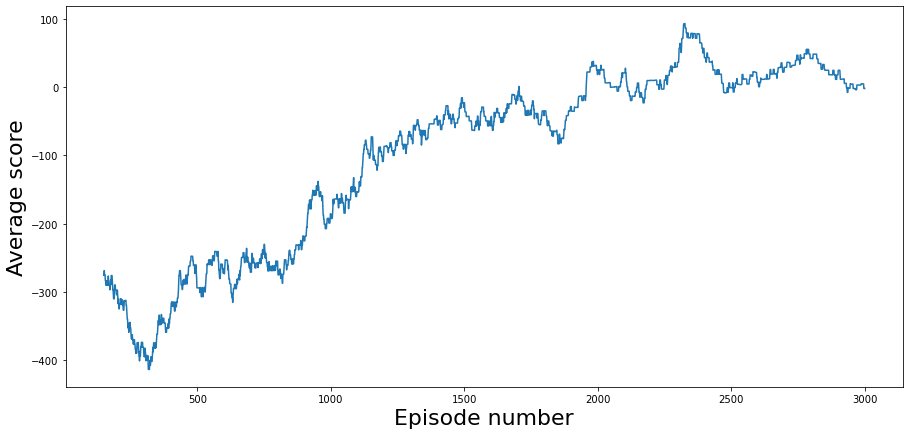

In [ ]:

plt.figure(figsize=(15,7))
plt.plot(pd.DataFrame(np.array(total_reward_list)).rolling(window=150).mean())
plt.xlabel("Episode number",fontsize=22)
plt.ylabel("Average score",fontsize=22)
save = pd.DataFrame(np.array(total_reward_list)).rolling(window=150).mean()
save.to_csv("Reward_PolicyTweaking_model_dense_78_512_128_128_128_epoch_3000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000")

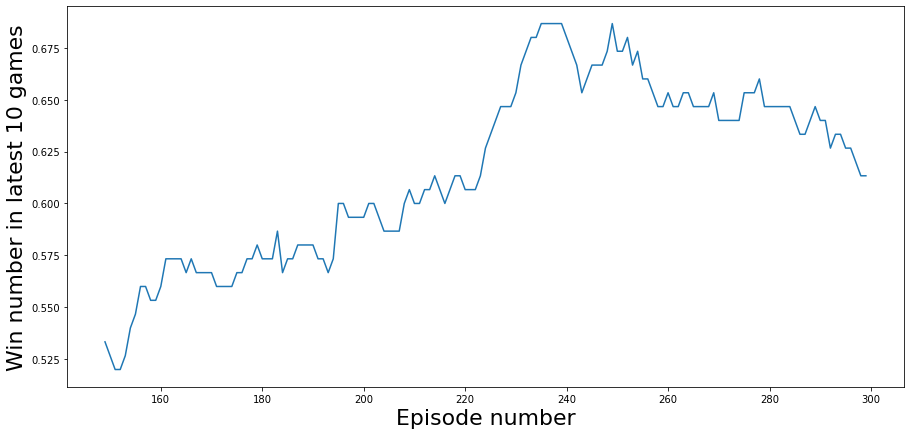

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(pd.DataFrame(np.array(win_num_list)).rolling(window=150).mean())
plt.xlabel("Episode number",fontsize=22)
plt.ylabel("Win number in latest 10 games",fontsize=22)
# plt.xticks(np.arange(0, 300, step=50))
plt.show()
save = pd.DataFrame(np.array(win_num_list)).rolling(window=150).mean()
save.to_csv("Win_PolicyTweaking_model_dense_78_512_128_128_128_epoch_3000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000")

<AxesSubplot:>

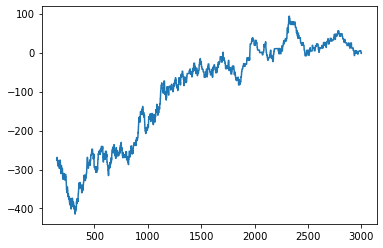

In [ ]:
(pd.read_csv("Reward_PolicyTweaking_model_dense_78_512_128_128_128_epoch_3000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000"))["0"].plot()

In [ ]:
model.save_weights('PolicyTweaking_model_dense_78_512_128_128_128_epoch_3000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000.h5')


## Testing

NOTE!: requires revision

In [ ]:
model.load_weights('PolicyTweaking_model_dense_78_512_128_128_128_epoch_3000_batch_128_mm_250_sync_500_gamma_85_ep_expdecay_90_03_memsize_10000000.h5')

In [ ]:
max_moves=250
def test_keras_model(model,display=True):
    clear_output(wait=True)
    i = 0
    test_game = Environment().initialize(4,4,0.2,True)[0]
    goldinPW = 1. if test_game.goldlocation == test_game.wumpuslocation or (test_game.goldlocation in test_game.pitlocations) else 0.
    stuck = 0
    die = 0
    winnogold = 0


    state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
    if display:
        print("Initial State:")
        print(test_game.visualize())
    status = 1
    while(status == 1):
        qval_ = model(state,training=False)
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.applyAction(action)
        state_ = test_game.render_np().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
        if display:
            print(test_game.visualize())
        reward = test_game.agent.currentreward
        total_reward = test_game.agent.totalreward
        if test_game.terminated:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (test_game.agent.totalreward))
            else:
                if goldinPW and action=='Climb':
                    status = 2
                    winnogold += 1.
                    if display:
                        print("Game won! Reward: %s" % (test_game.agent.totalreward),"choose to climb out without gold")
                else:
                    status = 0
                    die = 1
                    if display:
                        print("Game LOST. Reward: %s" % (test_game.agent.totalreward))
        i += 1
        if (i > max_moves):
            stuck=1
            if display:
                print("Game lost; too many moves.")
            break

    win = True if status == 2 else False
    pitnum = [0,0,0,0,0]
    win_in_pitnum = [0,0,0,0,0]
    num_of_pits = len(test_game.pitlocations)
    if num_of_pits == 0:
        pitnum[0]=1.
        if win:
            win_in_pitnum[0]=1.
    if num_of_pits == 1:
        pitnum[1]=1.
        if win:
            win_in_pitnum[1]=1.
    if num_of_pits == 2:
        pitnum[2]=1.
        if win:
            win_in_pitnum[2]=1.
    if num_of_pits == 3:
        pitnum[3]=1.
        if win:
            win_in_pitnum[3]=1.
    if num_of_pits >= 4:
        pitnum[4]=1.
        if win:
            win_in_pitnum[4]=1.
    print("Reward:", test_game.agent.totalreward, win,action)
    print(test_game.visualize())
    return win,total_reward,goldinPW,stuck,die,np.array(pitnum),np.array(win_in_pitnum),winnogold